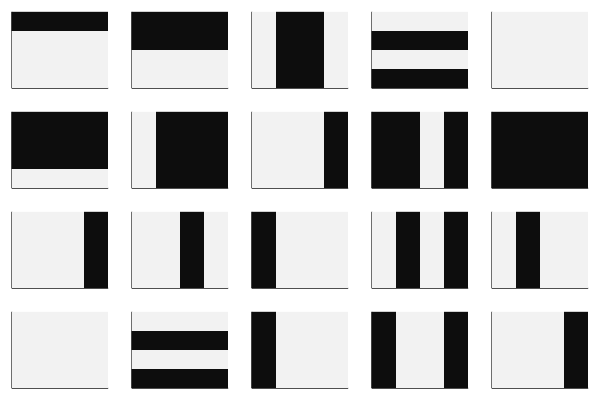

In [15]:
using Random
using Plots

n = 4
train = 20

#if repeats = false, need to find a way to not have duplicates
#check if train < 2^(n+1) - 2

function bars_and_stripes(train = 10, repeats = true) #Samples train data samples from the nxn bars_and_stripes synthetic dataset
    data = []
    for i in 1:train
        S = Int64[]
        while length(S) == 0 #Ensures length(S) is not 0 so we get truly uniform distribution over the whole bars and stripes dataset
            randsubseq!(S, collect(1:n), 0.5)
        end
        if 1 in S
            b = repeat(Bool[1], n)
        else
            b = repeat(Bool[0], n)
        end
        for i in 2:n
            temp = repeat(Bool[0], n)
            if i in S
                temp = repeat(Bool[1], n)
            end
            b = hcat(b, temp)
        end
        flip = rand() < 0.5
        if length(S) == n
            ret = flip ? b : .!b
        else
            ret = flip ? b : rotl90(b)
        end
        push!(data, ret)
    end
    return data
end

data_train = bars_and_stripes(train) #Stores data in data_train

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)

In [16]:
using Yao
using Flux

N = n^2 #Number of qubits

#Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) 
# Use CNN (because it's currently very bad at distinguishing images)
# Writing a discriminator in Pytorch is better?

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
#To enhance expressibility:
# Change circuit ansatz to include more generators
# Change pprior() to become nonconstant
# Gradient doesn't change if you sample from a nonconstant distribution of states? As opposed to all zero state
# Can prove this analytically
# Run on GPU?

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, :random)
dispatch!(g, rand(nparams).*2π)
println(parameters(g))

Number of parameters in discriminator: 181


Number of parameters in generator: 230
[1.0795413160360365, 4.26728866882933, 4.493187370924748, 1.6844878124476044, 4.600072923812831, 3.7435330655506998, 4.571809188077461, 3.5067729740109685, 0.32856196470109394, 2.5705517910574915, 5.789951334059913, 5.799270776892371, 3.5021518667540246, 2.4920890681170778, 1.82014973274241, 0.2071018046485315, 1.493776695721572, 5.767130822195675, 2.6933651257236675, 5.933132996039979, 6.153415766023828, 0.24409088305187146, 3.46056220390284, 1.2921136369274144, 0.19838515534552922, 0.5161467606075302, 1.8951694379747293, 4.079635176016901, 1.2074758966379449, 1.371908785247487, 1.738181060025951, 0.17213846837250868, 1.7379008173339743, 0.350845793613467, 0.48256260197510387, 4.067200680406281, 2.1628319338865345, 4.934531649894413, 3.9704286534851585, 6.1069921654321515, 3.489143111576522, 4.462423144845059, 6.174928743540157, 6.155078905510234, 0.3836218491109786, 4.352169242644453, 1.21917393921815, 5.720827336216492, 2.2430696160998687, 4.43

Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

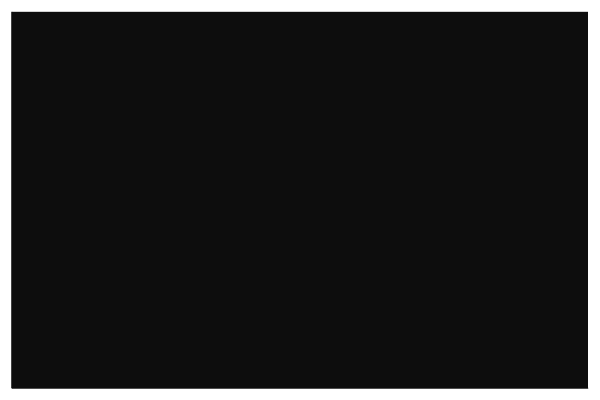

In [17]:
# using FLOYao
# using Random
# using Distributions

# mu = mean(trainstats)
# sigma = std(trainstats)
# println("μ: $mu")
# println("σ: $sigma")
# #dist = Normal(mu, sigma/20)
# dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 0 #if ratio = 0 then pprior() is all 0s
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, n, n)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [18]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 100 #This doesn't need to be that big
dispatch!(g, rand(nparams).*2π)
function run_g(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(; theta = parameters(g), nbatch = samplemean_batch)
    -mean(log.(run_d_fake(run_g(theta = theta, nbatch = nbatch))))
end

#Ideally... but how do u get gradients to go down? do we just not use flux train? tbh i'm ok with that but then i need to figure out how else to implement optimization stuff (maybe use python)
# function dLoss(nbatch = samplemean_batch)
#     real = mean(log.(run_d_real()))
#     fake = mean(log.(1 .- run_d_fake(run_g(nbatch))))
#     -(real + fake)
# end

#This is only formatted like this in order to use Flux.train!
#So maybe I shouldn't use it?
function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

gLoss()

0.94649947f0

In [19]:
# using Plots
# using Statistics

# p = []
# for _ in 1:500
#     push!(p, gLoss())
# end

# histogram(p, bins=20, xlabel="gLoss", ylabel="Frequency")

# #@time gLoss() #It's still decently spread out...

In [20]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss() #This is the problem
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

#println(finitediff_grad())
#Computing gradients is slow and also I'm still getting different results for parametershift and finitediff
#parametershift prints very small numbers and finitediff prints very big numbers...

# for _ in 1:10
#     println(parametershift_grad()) #Should print similar numbers...
# end

parametershift_grad (generic function with 2 methods)

In [31]:
g_lr = 1e-3
d_lr = 1e-3

d_opt = Flux.setup(Adam(), d) 

gLoss_vals = []
dLoss_vals = []
mean_grads = []
dreal_vals = []
dfake_vals = []
g_params = []
d_params = []

g_epochs = 1
d_epochs = 1
epochs = 1
batch = train

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        ∇ = parametershift_grad()
        push!(mean_grads, mean(∇))
        dispatch!(-, g, ∇ * g_lr)
        push!(gLoss_vals, gLoss())
    end
    push!(g_params, parameters(g))
    for j in 1:d_epochs
        real = []
        fake = []
        for m in 1:batch
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            push!(fake, run_g(nbatch = 1))
        end
        data = collect(zip(real, fake)) 
        println(data)
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_vals, s / batch)
    end
    push!(d_params, Flux.params(d))
    d_fake = first(run_d_fake(run_g(nbatch = 1)))
    push!(dfake_vals, d_fake)
    index = rand(1:train)
    d_real = data_train[index] |> vec |> d |> first
    push!(dreal_vals, d_real)
    println("iteration $i done in: ", time() - t)
end

#last g_epochs of training for the generator, because we want g to be good, don't really care about d
for _ in 1:g_epochs
    dispatch!(-, g, parametershift_grad() * g_lr)
    push!(gLoss_vals, gLoss())
end

Tuple{Any, Any}[([1, 1, 1, 0, 1, 1, 1, 0, 1, 

1, 1, 0, 1, 1, 1, 0], [1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]), ([1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0], [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]), ([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], [1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]), ([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]), ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0]), ([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]), ([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]), ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]), ([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0]), ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]), ([1, 1, 1

Generator loss
Any[0.9530853f0, 0.9210655f0, 0.93290085f0, 0.97040915f0, 0.90130717f0, 0.9464855f0, 0.9358659f0, 0.96205527f0, 0.926423f0, 0.9613483f0, 0.94126946f0, 1.0015224f0, 0.93627334f0, 0.9471718f0, 0.94524074f0, 0.96733016f0, 0.9069012f0, 0.9389772f0, 0.92946464f0, 0.94289124f0, 0.85315686f0, 0.83083445f0, 0.8298571f0, 0.87244827f0, 0.8976136f0, 0.87985057f0, 0.83518404f0, 0.872642f0, 0.8193589f0, 0.85735154f0, 0.8463363f0, 0.82283044f0, 0.8367615f0, 0.86679757f0, 0.8309225f0, 0.81597173f0, 0.84167266f0, 0.8400584f0, 0.8751874f0, 0.8326016f0, 0.74109477f0, 0.7684128f0, 0.790872f0, 0.79749304f0, 0.7889551f0, 0.7955789f0, 0.8221003f0, 0.75640404f0, 0.7479374f0, 0.7985723f0, 0.78624403f0, 0.79616654f0, 0.76128495f0, 0.7978318f0, 0.79194045f0, 0.7812852f0, 0.7671316f0, 0.7908424f0, 0.7979095f0, 0.7507327f0, 0.7568713f0, 0.7420527f0, 0.72900087f0, 0.73740596f0, 0.73285425f0, 0.740736f0, 0.71234155f0, 0.7092413f0, 0.7171178f0, 0.728757f0, 0.70790046f0, 0.76587707f0, 0.7474855f0, 0.74

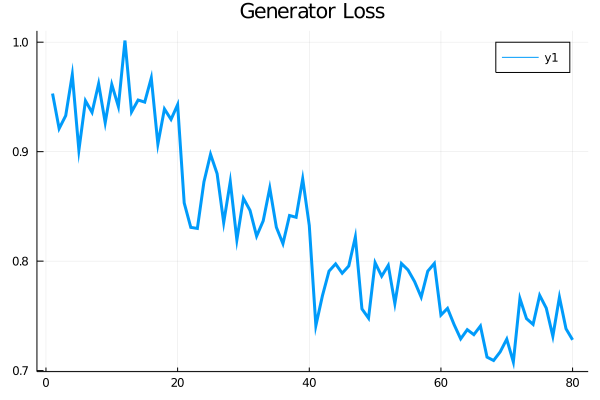

In [22]:
println("Generator loss")

println(gLoss_vals)
# for l in gLoss_values
#     println(l)
# end

plot(gLoss_vals, title = "Generator Loss", linewidth=3)

Discriminator loss
Any[1.4167418f0, 1.3788617f0, 1.3408415f0]


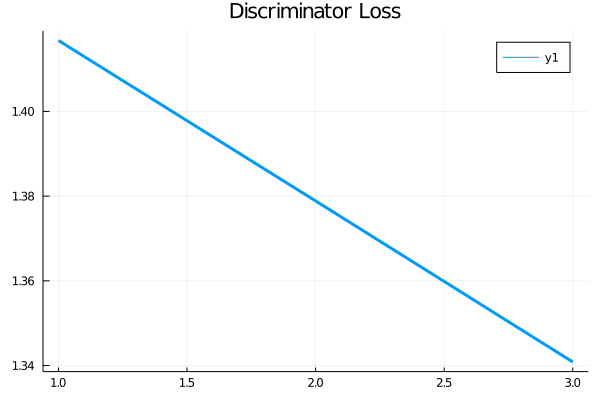

In [23]:
println("Discriminator loss")

println(dLoss_vals)
# for l in dLoss_values
#     println(l)
# end

plot(dLoss_vals, title = "Discriminator Loss", linewidth=3)

Mean gradients
Any[0.0016745660616003949, 0.002362628734630087, 2.683984196704367e-5, 0.0011276766009952711, 0.0011651217937469482, 0.0016042136627694836, 0.0003798965526663739, 0.0016495581554329913, 0.0018695627865584, 0.0018980216720829838, 0.0009281692297562309, 4.0040975031645405e-5, 0.00048181375731592594, 0.002901699361593827, 0.0015234596055486928, 0.0014623816894448322, 0.0005625341249548871, 0.0008538194324659265, 0.003239121773968572, 0.00043044090270996096, 0.0008016816947771156, 0.0026109951993693475, -5.4705272550168245e-5, 0.002840289991834889, 0.0025798473669135054, -3.768957179525624e-5, 0.00201489666233892, 0.0010680355455564416, 0.0017680271812107252, 0.0014831903188124947, 0.0017152013986007028, 0.0003280139487722646, 0.0011687211368394935, 0.00147212160670239, 0.0015585739975390227, -0.0004012098778849063, 0.0008290622545325237, 0.001321121272833451, 0.0014857336230899977, 0.003243901807328929, 0.002181618369143942, 0.00038828474024067754, -1.4584090398705524e-5, -

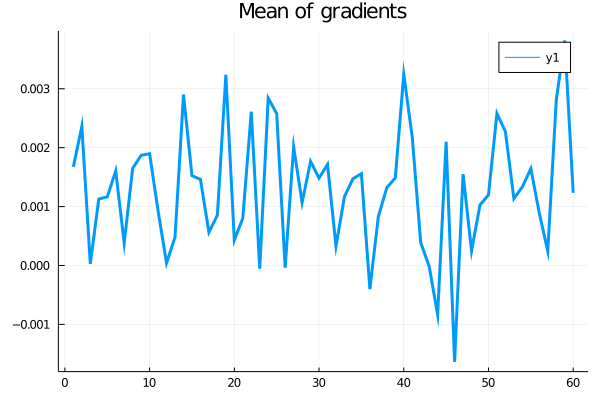

In [24]:
println("Mean gradients")

println(mean_grads)
# for l in dLoss_values
#     println(l)
# end

plot(mean_grads, title = "Mean of gradients", linewidth=3)

In [25]:
println(epochs)

3


In [26]:
#Testing the Discriminator

d_iter = epochs

d_fake = first(run_d_fake(run_g(nbatch = 1)))
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = data_train[index] |> vec |> d |> first
println("real data: $d_real") #Should print a number close to 1

fake data: 0.5247882
real data: 0.5667185


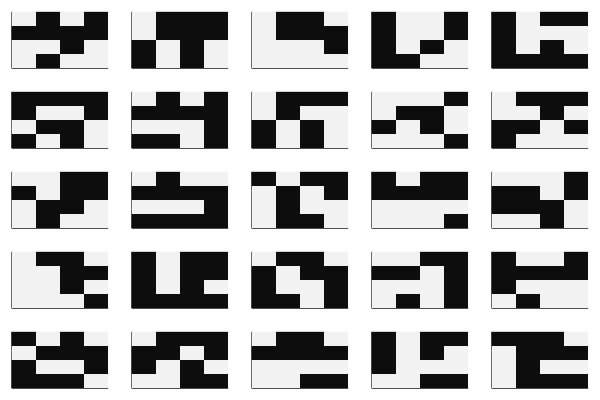

In [30]:
#Testing the Generator

g_iter = 3

dispatch!(g, g_params[g_iter]) #Reverts parameters of g to the g_iter th training epoch

nsamples = 25
samples = run_g(nbatch = nsamples)
plot([heatmap(reshape(samples[:, i], n, n), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)

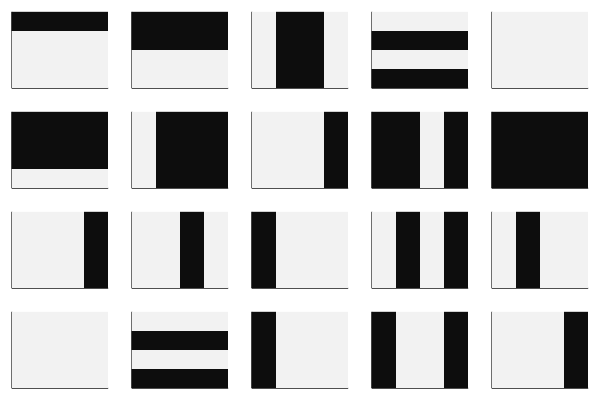

In [28]:
plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)